<a href="https://colab.research.google.com/github/vadhri/ai-notebook/blob/main/aml/extraction/cve-2019-20634.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uq datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 7.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cud

In [2]:
import pandas as pd
import base64
import numpy as np
import matplotlib.pyplot as plt
import torch

from datasets import Dataset, DatasetDict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from transformers import AutoModelForSequenceClassification, AutoTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
!wget https://raw.githubusercontent.com/moohax/Proof-Pudding/refs/heads/master/core/data/texts.csv

--2025-02-08 11:31:00--  https://raw.githubusercontent.com/moohax/Proof-Pudding/refs/heads/master/core/data/texts.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14542059 (14M) [text/plain]
Saving to: ‘texts.csv’

texts.csv           100%[===================>]  13.87M  --.-KB/s    in 0.09s   

2025-02-08 11:31:02 (146 MB/s) - ‘texts.csv’ saved [14542059/14542059]



In [4]:
df = pd.read_csv("texts.csv")

# Decode the subject from base64
df["subject"] = (
    # encode the strings to bytes
    df["subject"].str.encode("utf-8", "strict")
    # decode each byte string
    .apply(base64.b64decode)
    # decode the bytes back to UTF-8
    .str.decode("utf-8")
)

# Decode the content from base64 encoding (same as above)
df["content"] = (
    df["content"].str.encode("utf-8", "strict")
    .apply(base64.b64decode)
    .str.decode("utf-8")
)

df.head()

,subject,content,rule,policy,score,bulkscore,malwarescore,priorityscore,spamscore,phishscore,...,lowpriorityscore,suspectscore,adultscore,clxscore,classifier,adjust,reason,scancount,engine,definitions
0,Enron,\nMr. Lay:\nI am a former Enron employee. I u...,nodigest_notspam,nodigest,0,2,0,0,0,0,...,2,3,0,495,spam,0,mlx,1,8.12.0-1906280000,main-1908280184
1,Homestead Expansion - Update,The Homestead precedent agreements are going o...,nodigest_notspam,nodigest,0,0,0,0,0,0,...,0,3,0,465,spam,0,mlx,1,8.12.0-1906280000,main-1908280183
2,XMS Upgrade Transition Plan - All XMS Users Pl...,\r\n \t\tConcur Expense (XMS) Upgrade!\r\n\...,nodigest_notspam,nodigest,0,0,0,0,0,0,...,0,3,0,515,spam,0,mlx,1,8.12.0-1906280000,main-1908280182
3,St. Dominics,Oops. Can you forward my response to Margaret...,nodigest_notspam,nodigest,0,0,0,0,0,0,...,0,3,0,515,spam,0,mlx,1,8.12.0-1906280000,main-1908280184
4,VAR 12/28/01,As an aside?.\n\tNormal\t\t\tHistorical Vol\nC...,nodigest_notspam,nodigest,0,0,0,0,0,0,...,0,3,0,432,spam,0,mlx,1,8.12.0-1906280000,main-1908280184


In [5]:
df.describe(include="all")


,subject,content,rule,policy,score,bulkscore,malwarescore,priorityscore,spamscore,phishscore,...,lowpriorityscore,suspectscore,adultscore,clxscore,classifier,adjust,reason,scancount,engine,definitions
count,9898,9898,9898,9898,9898.000000,9898.000000,9898.0,9898.000000,9898.000000,9898.0,...,9898.000000,9898.000000,9898.000000,9898.000000,9898,9898.0,9898,9898.000000,9898,9898
unique,7089,8675,1,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,NaN,1,NaN,1,7
top,No Subject,"\nAs you know, Enron has signed a merger agree...",nodigest_notspam,nodigest,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,spam,NaN,mlx,NaN,8.12.0-1906280000,main-1908280184
freq,330,27,9898,9898,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,9898,NaN,9898,NaN,9898,3682
mean,NaN,NaN,NaN,NaN,0.037078,2.214488,0.0,14.796828,0.037078,0.0,...,2.214488,3.705294,0.084462,487.993029,NaN,0.0,NaN,1.000606,NaN,NaN
std,NaN,NaN,NaN,NaN,1.050863,13.954275,0.0,69.776046,1.050863,0.0,...,13.954275,3.883852,1.291557,47.859147,NaN,0.0,NaN,0.024615,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,308.000000,NaN,0.0,NaN,1.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,3.000000,0.000000,456.000000,NaN,0.0,NaN,1.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,3.000000,0.000000,490.000000,NaN,0.0,NaN,1.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,3.000000,0.000000,515.000000,NaN,0.0,NaN,1.000000,NaN,NaN


In [6]:
df.drop(columns=[x for x in df.columns if len(df[x].unique()) == 1], inplace=True)

In [7]:
interesting = ["score", "mlxlogscore", "clxscore", "adultscore", "priorityscore", "spamscore", "mlxscore", "suspectscore", "lowpriorityscore"] # add more columns
df[interesting].head()

,score,mlxlogscore,clxscore,adultscore,priorityscore,spamscore,mlxscore,suspectscore,lowpriorityscore
0,0,875,495,0,0,0,0,3,2
1,0,701,465,0,0,0,0,3,0
2,0,999,515,0,0,0,0,3,0
3,0,771,515,0,0,0,0,3,0
4,0,775,432,0,0,0,0,3,0


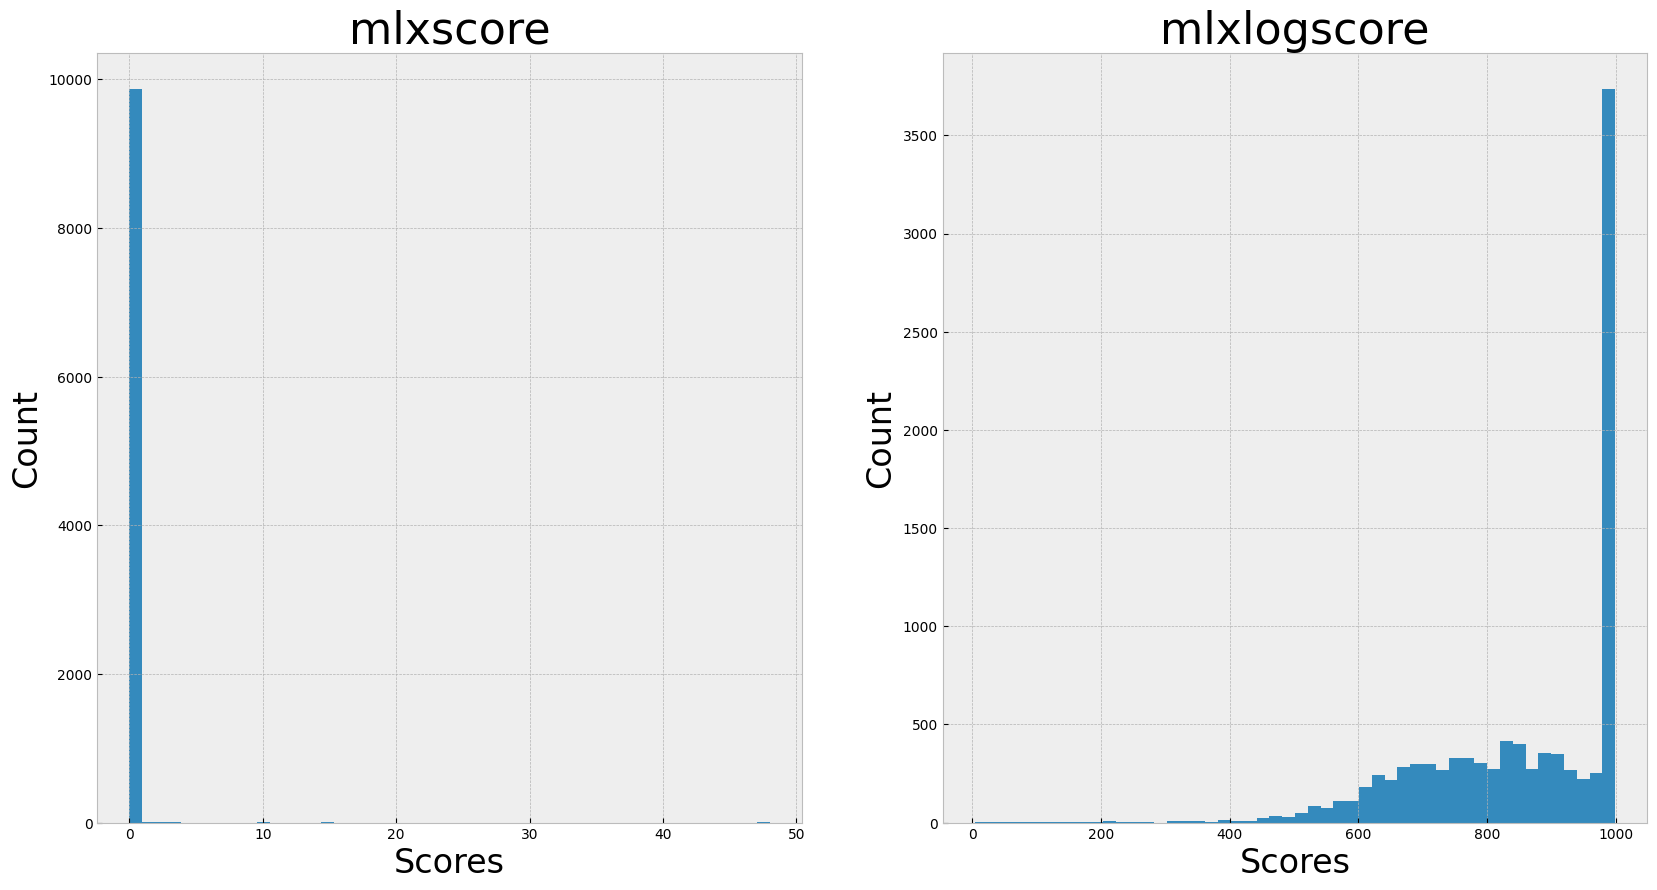

In [8]:
with plt.style.context("bmh"):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].hist(x=df["mlxscore"], bins=50)
    ax[0].set_title("mlxscore", fontdict={"fontsize": 32})
    ax[0].set_xlabel("Scores", fontdict={"fontsize": 24})
    ax[0].set_ylabel("Count", fontdict={"fontsize": 24})
    ax[1].hist(x=df["mlxlogscore"], bins=50)
    ax[1].set_title("mlxlogscore", fontdict={"fontsize": 32})
    ax[1].set_xlabel("Scores", fontdict={"fontsize": 24})
    ax[1].set_ylabel("Count", fontdict={"fontsize": 24})
plt.show()

# Visualization - correlation plot

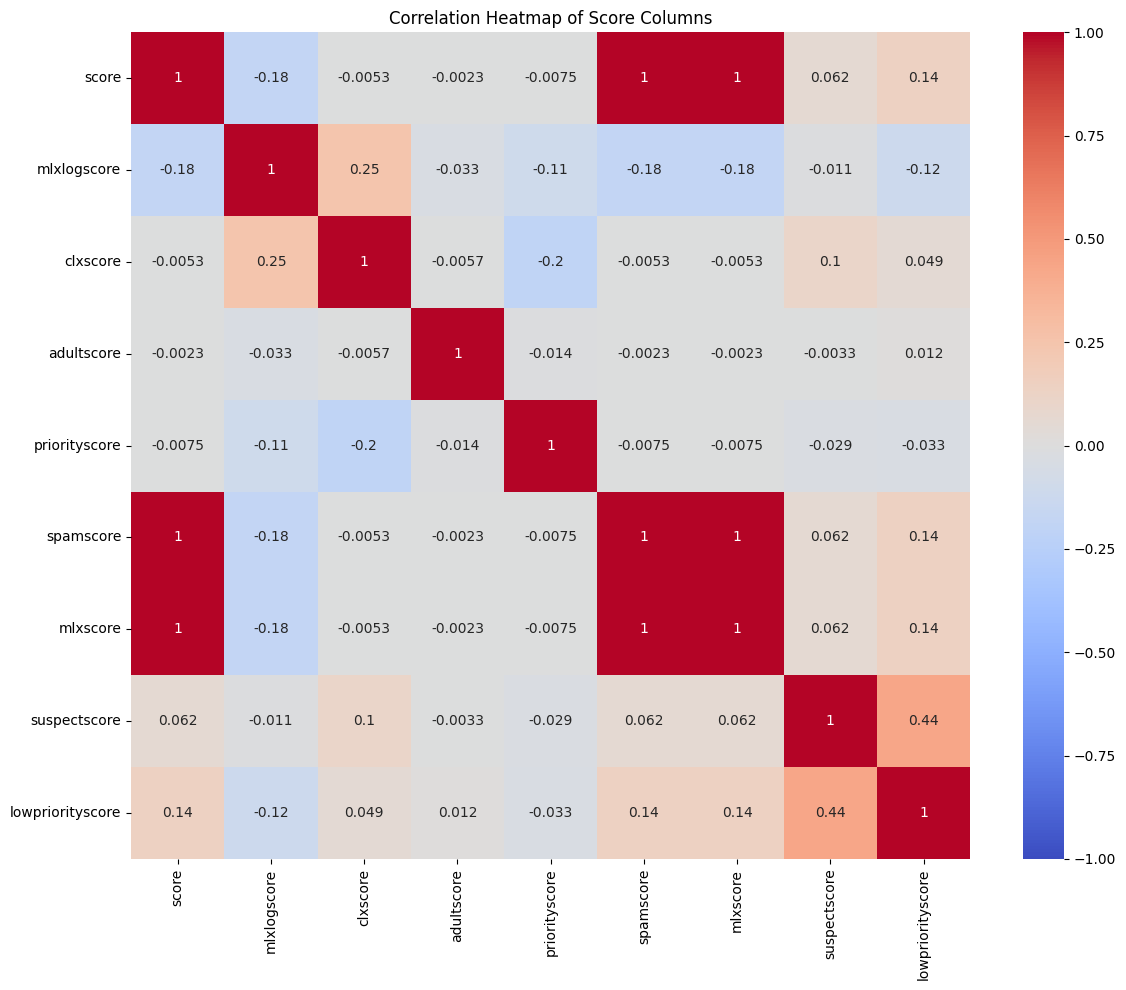

In [9]:
import seaborn as sns

correlation_matrix = df[interesting].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Score Columns')
plt.tight_layout()
plt.show()

mlxscore is correlated to spamscore and score coloumns.

# Visualization - Pair plots

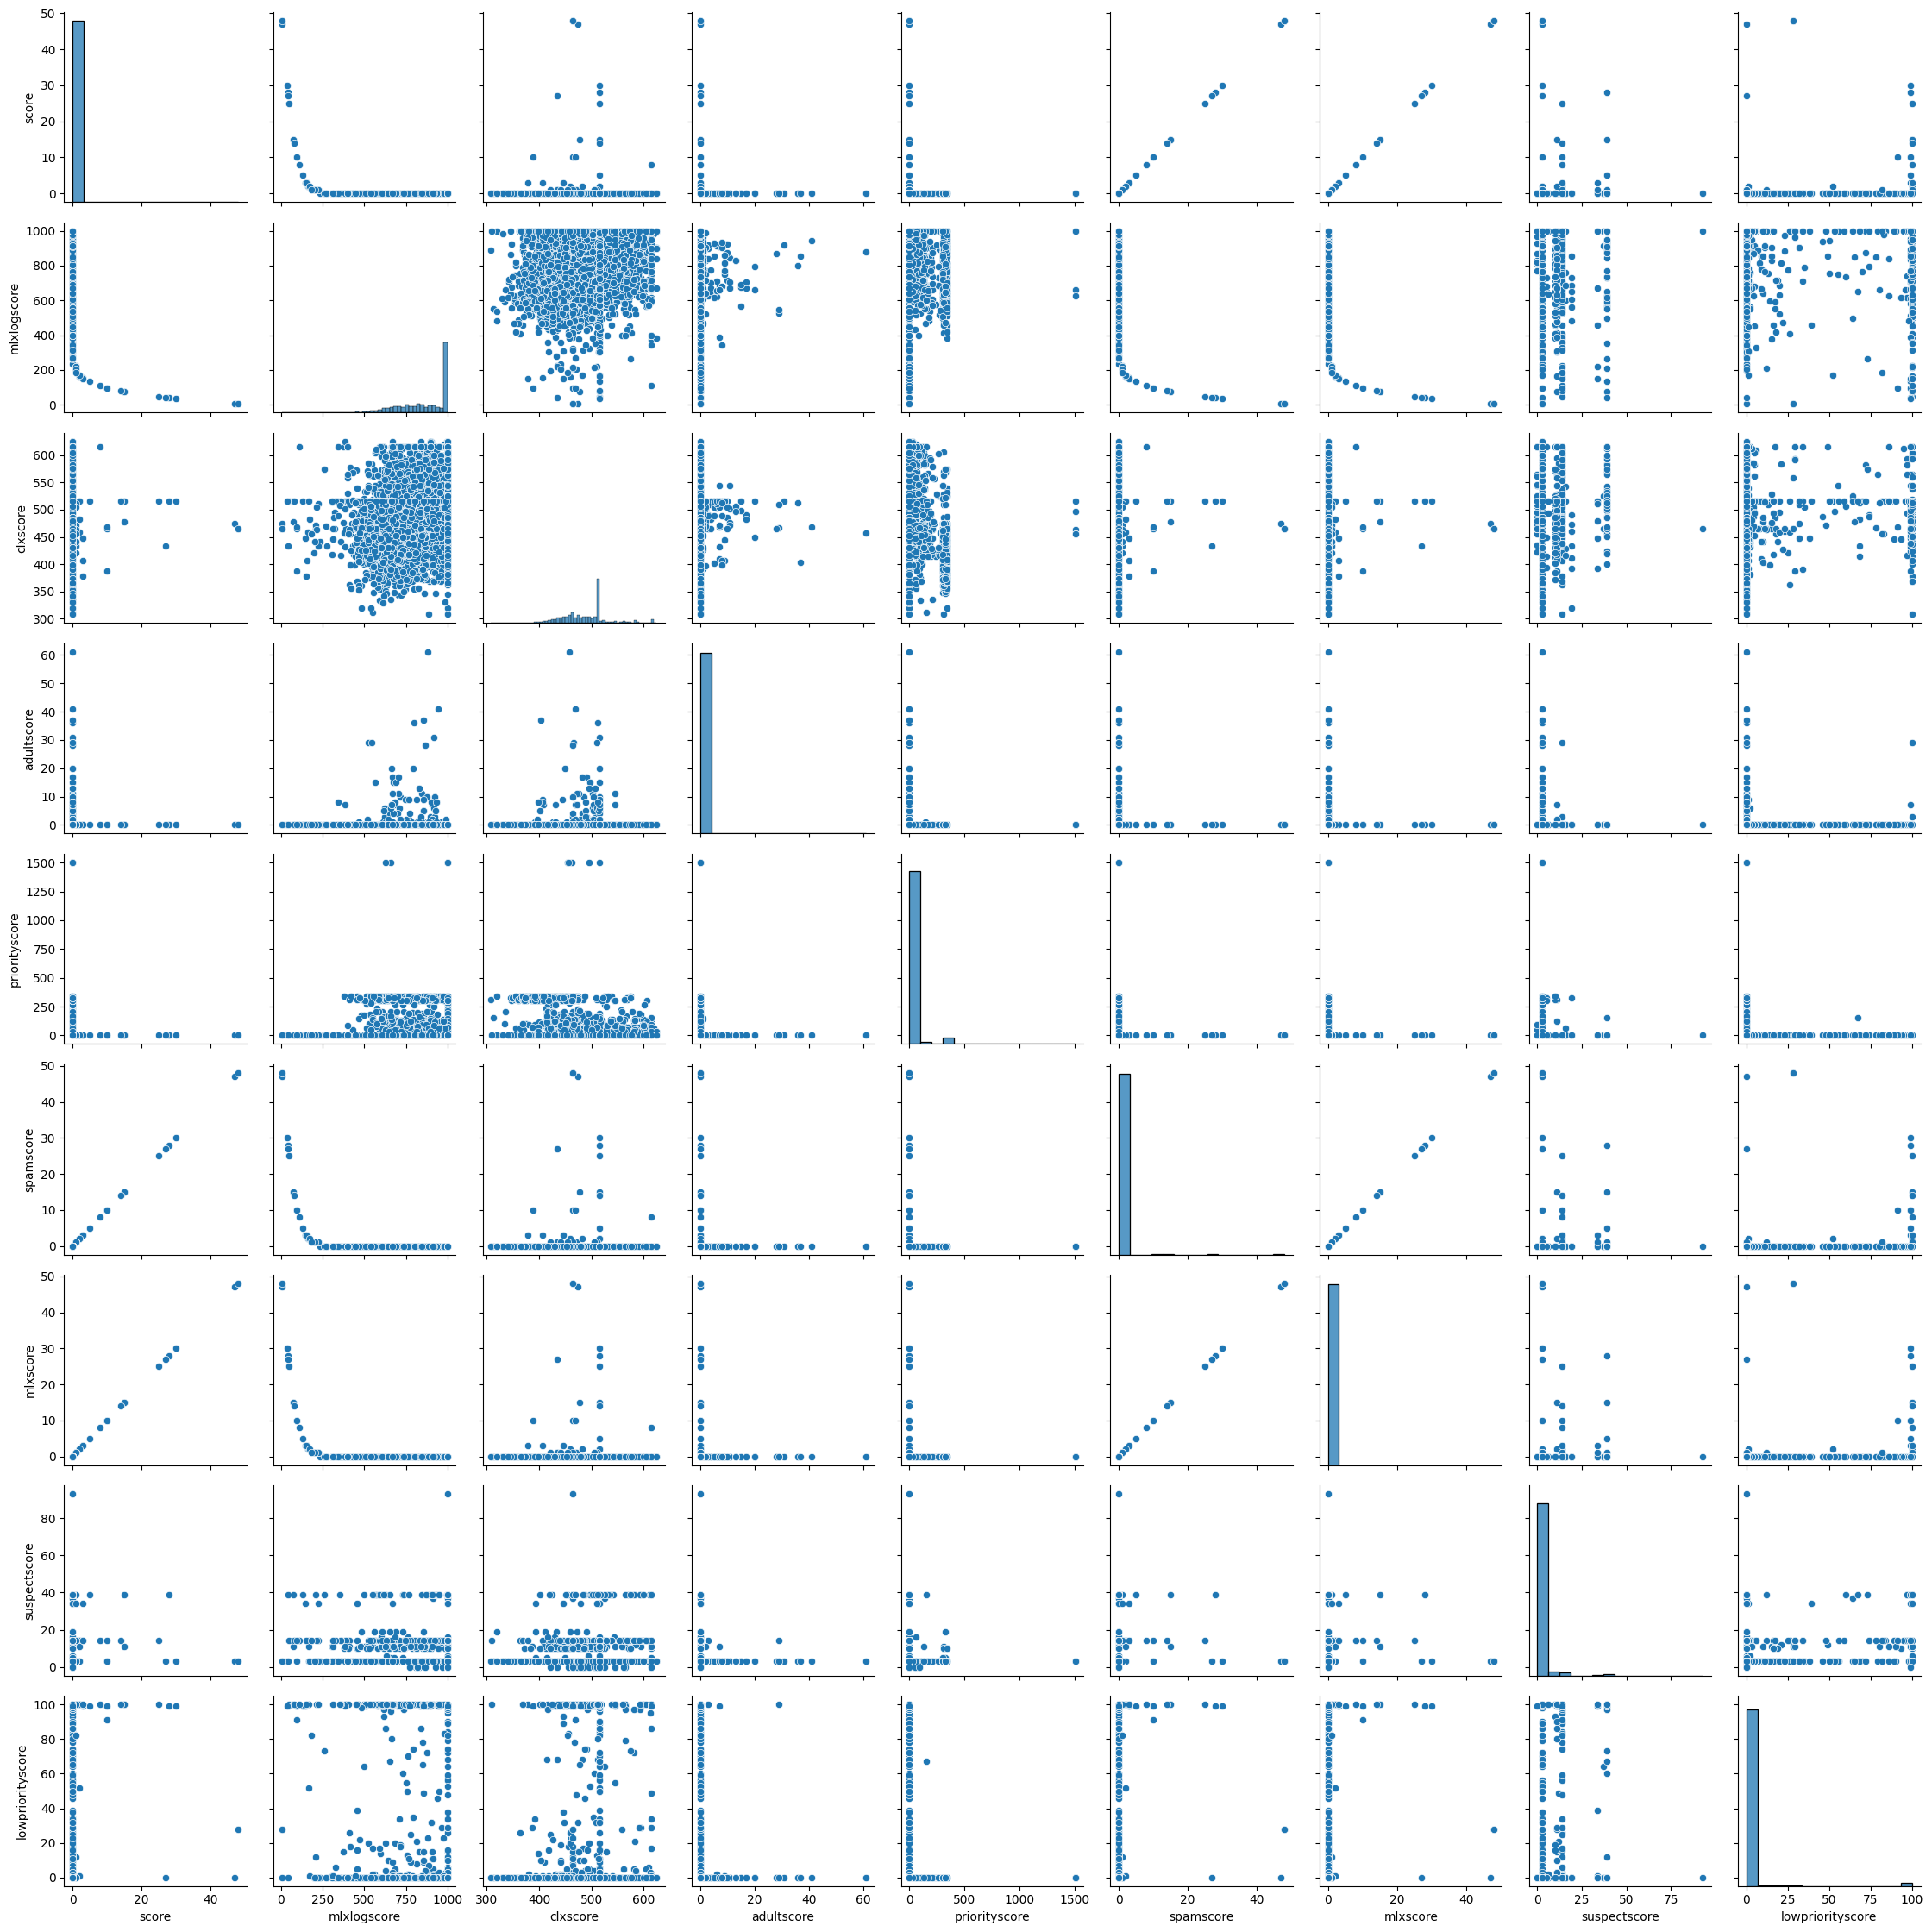

In [10]:
sns.pairplot(df[interesting])
plt.tight_layout()
plt.show()

<Axes: >

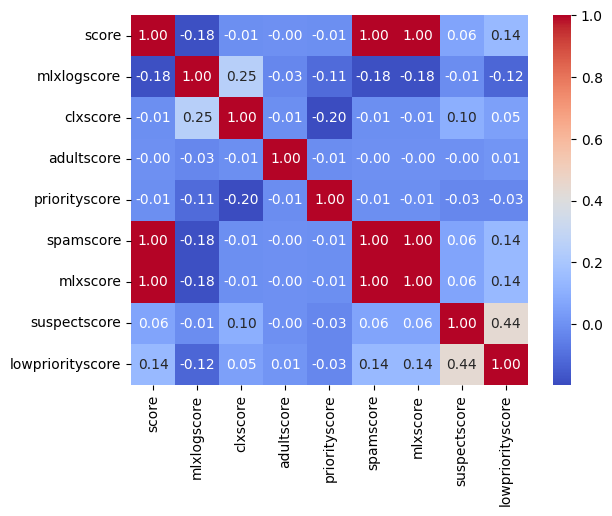

In [11]:
sns.heatmap(df[interesting].corr(), annot=True, cmap='coolwarm', fmt=".2f")

## Term frequency inverse document frequency (TFIDF)

In [12]:
vectorizer = TfidfVectorizer(stop_words="english", min_df=0.001, ngram_range=(1, 2))
vec = vectorizer.fit(df["content"])

word_doc_matrix = vec.transform(df["content"])
word_doc_matrix

<9898x15080 sparse matrix of type '<class 'numpy.float64'>'
	with 737334 stored elements in Compressed Sparse Row format>

_check_stop_list

In [13]:
pca = PCA(
    n_components=2
)  # 2 components because we're going to create a 2 dimensional plot
pca_data = pca.fit_transform(word_doc_matrix.toarray())
print("[+] Done")

[+] Done


In [14]:
# DO NOT CHANGE

# Perform dimensionality reduction on the word-document matrix using t-SNE
embedded_content = TSNE(
    n_components=2, # again, 2 components for 2d plotting

    # Set the perplexity hyperparameter (affects the clustering behavior)
    perplexity=50, # this is the most significant hyperparameter. Feel free to adjust and see how it changes the shape

    # Set the learning rate to "auto" (adaptive learning rate)
    learning_rate="auto",

    # Use the cosine metric for distance calculations
    metric="cosine",

    # Initialize the embedding to be random
    init="random",

    # Use squared distances
    # square_distances=True,

    # parallelize all available cores
    n_jobs=-1,

).fit_transform(word_doc_matrix)

print("[+] Done")


[+] Done


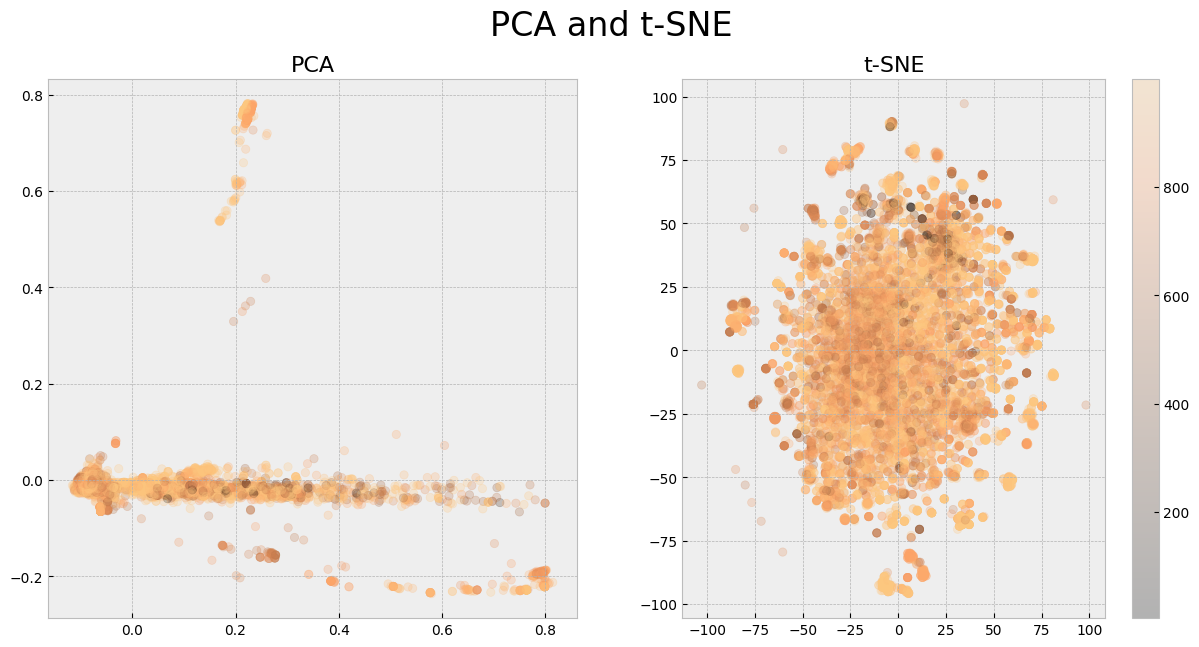

In [15]:
# DO NOT CHANGE

with plt.style.context("bmh"):
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    ax0 = ax[0].scatter(
        x=pca_data[:, 0],
        y=pca_data[:, 1],
        c=df["mlxlogscore"],
        cmap="copper",
        alpha=0.25,
    )
    ax[0].set_title("PCA", fontsize=16)
    ax1 = ax[1].scatter(
        x=embedded_content[:, 0],
        y=embedded_content[:, 1],
        c=df["mlxlogscore"],
        cmap="copper",
        alpha=0.25,
    )
    ax[1].set_title("t-SNE", fontsize=16)
    fig.colorbar(ax1)
    fig.suptitle("PCA and t-SNE", fontsize=24)
plt.show()

In [16]:
email = 13

print(f"Raw email:\n{df.iloc[email]['content']}")
print(f"Processed email:\n{vec.build_analyzer()(df.iloc[email]['content'])}")

Raw email:
In order to ensure that our contact list is complete, we are asking the head of every Enron office/facility to provide 24-hour contact information to john.brindle@enron.com.  Thank you.

Processed email:
['order', 'ensure', 'contact', 'list', 'complete', 'asking', 'head', 'enron', 'office', 'facility', 'provide', '24', 'hour', 'contact', 'information', 'john', 'brindle', 'enron', 'com', 'thank', 'order ensure', 'ensure contact', 'contact list', 'list complete', 'complete asking', 'asking head', 'head enron', 'enron office', 'office facility', 'facility provide', 'provide 24', '24 hour', 'hour contact', 'contact information', 'information john', 'john brindle', 'brindle enron', 'enron com', 'com thank']


In [17]:
df1 = pd.DataFrame(word_doc_matrix.toarray(), columns=vec.get_feature_names_out())
df1["mlxlogscore"] = df["mlxlogscore"]
features = [x for x in df1.columns.tolist() if x not in ["mlxlogscore"]]
corrs = df1[features].corrwith(df1["mlxlogscore"], numeric_only=True)
corrs = corrs.sort_values()
print("[+] Done")

[+] Done


In [18]:
for i in range(5):
    print(f"Spammy: {corrs.index[i] : <20}\tHammy: {corrs.index[-(i+1)] : >10}")

Spammy: attached            	Hammy:      enron
Spammy: click unsubscribe   	Hammy:  enron com
Spammy: image               	Hammy:     create
Spammy: gmt 06              	Hammy:       date
Spammy: central time        	Hammy:     report


<ipython-input-20-0c5ee55cd5fa>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.set_ylim((corrs[0] - 0.05, corrs[-1] + 0.05))


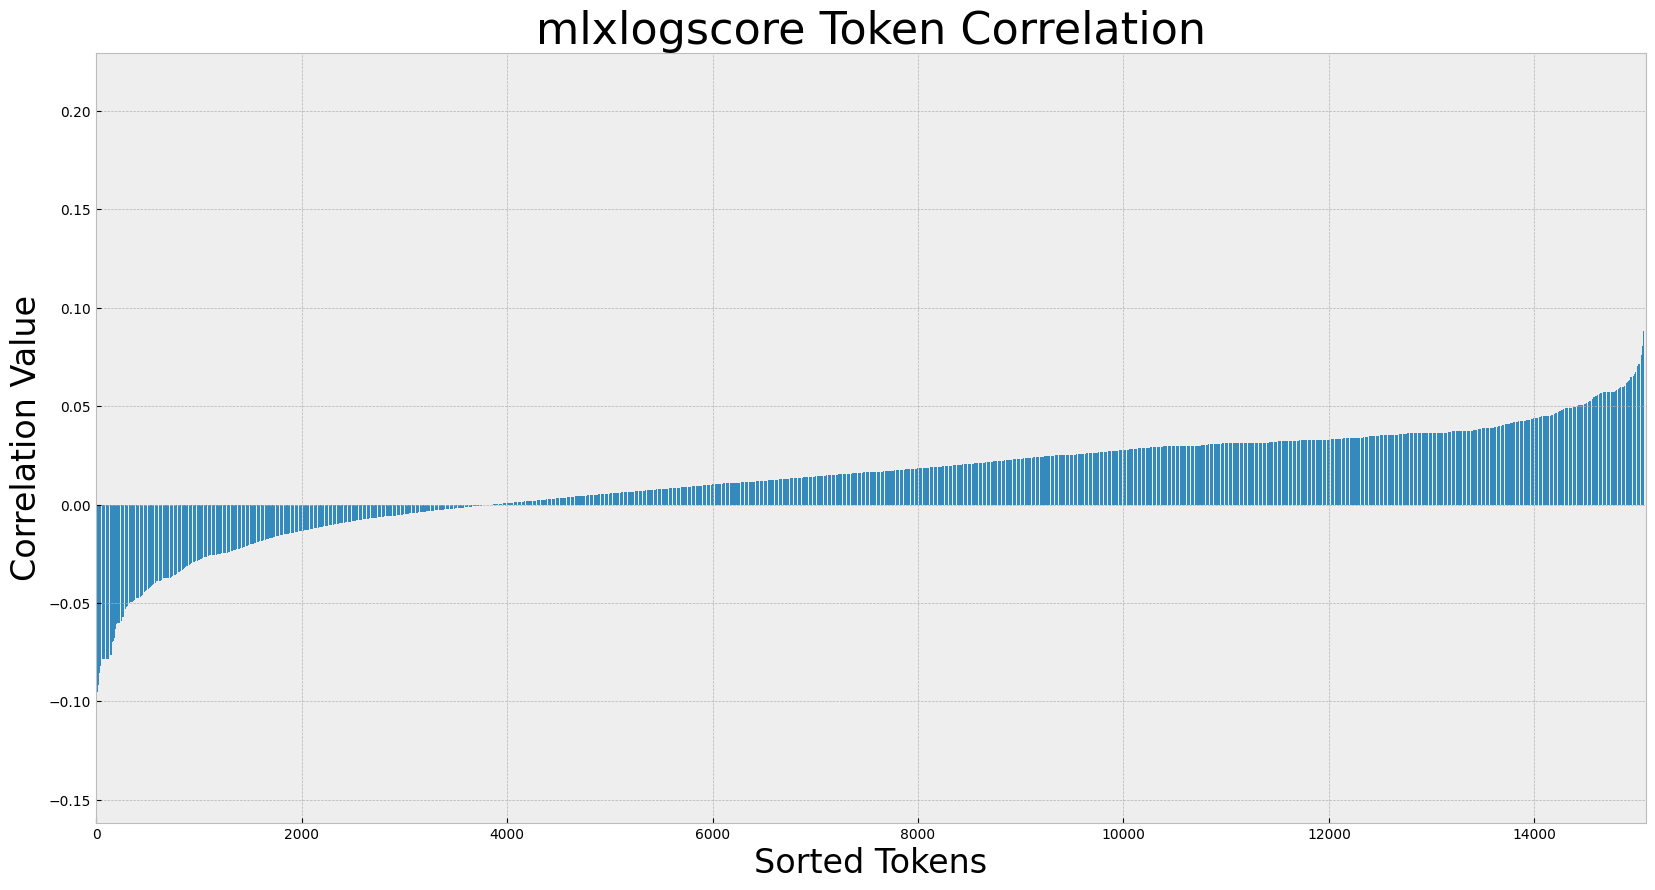

In [20]:
with plt.style.context("bmh"):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.bar(x=[i for i in range(len(corrs))], height=corrs)
    ax.set_xlim((-5, len(corrs) + 5))
    ax.set_ylim((corrs[0] - 0.05, corrs[-1] + 0.05))
    ax.set_title("mlxlogscore Token Correlation", fontdict={"fontsize": 32})
    ax.set_xlabel("Sorted Tokens", fontdict={"fontsize": 24})
    ax.set_ylabel("Correlation Value", fontdict={"fontsize": 24})
plt.show()

In [21]:
# 1. Pick a word and find out how correlated it is (or isn't) to `mlxlogscore`.
# There is no way to form a correlation with missing word.

word_to_check = "meeting"

if word_to_check in df1.columns:
    correlation = df1[word_to_check].corr(df1["mlxlogscore"])
    print(f"The correlation between '{word_to_check}' and 'mlxlogscore' is: {correlation}")
else:
    print(f"'{word_to_check}' not found in the vocabulary.")


The correlation between 'meeting' and 'mlxlogscore' is: 0.036705807173325014


In [22]:
# DO NOT CHANGE

# this is the model we want to train
model_name = "bert-base-uncased"

# add the preprocessor
tokenizer = AutoTokenizer.from_pretrained(model_name)
max_len = 512

encodings = tokenizer(df['content'].tolist(), truncation=True, padding="max_length", max_length=max_len)

# Extract input ids, masks and convert to tensors
input_ids = torch.tensor(encodings.input_ids)
attention_masks = torch.tensor(encodings.attention_mask)

# provided code
labels = torch.tensor(df['mlxlogscore'].values).float()

threshold = 100

# Relabel data at threshold
labels = (labels >= threshold).long()

# Create DatasetDict
hf_dataset = Dataset.from_dict(
    {
        'input_ids': input_ids.tolist(),
        'attention_masks': attention_masks.tolist(),
        'labels': labels.tolist()
    }
)

train_test = hf_dataset.train_test_split(test_size=0.2)
train_dataset = train_test['train']
test_dataset = train_test['test']

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [23]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
# DO NOT CHANGE

from transformers import TrainingArguments, Trainer

# Define the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
)

# Create a Trainer
trainer = Trainer(
    model=model,                     # the instantiated 🤗 Transformers model to be trained
    args=training_args,              # training arguments, defined above
    train_dataset=train_dataset,     # training dataset
    eval_dataset=test_dataset        # eval dataset
)

# Train the model
trainer.train()


# This is going to take ~10 minutes

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: vadhri-venkat to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Step,Training Loss
100,0.266100
200,0.010000
300,0.010300
400,0.021400
500,0.000400
600,0.013700
700,0.006300
800,0.029400
900,0.000500
1000,0.006400


TrainOutput(global_step=1485, training_loss=0.0274310898474772, metrics={'train_runtime': 5859.4761, 'train_samples_per_second': 4.054, 'train_steps_per_second': 0.253, 'total_flos': 6249940009021440.0, 'train_loss': 0.0274310898474772, 'epoch': 3.0})

In [25]:
# Evaluate on the validation set
eval_results = trainer.evaluate()

print(f"Validation results: {eval_results}")

Validation results: {'eval_loss': 0.004755126312375069, 'eval_runtime': 53.881, 'eval_samples_per_second': 36.748, 'eval_steps_per_second': 0.575, 'epoch': 3.0}


In [26]:
model.eval() # we did just eval. But just in case...you can't be too careful.

example = tokenizer("Please click on this link", return_tensors="pt") # insert your own string to test

with torch.no_grad():
    outputs = model(**example.to(device))

predictions = outputs.logits.argmax(-1)
print(f"Prediction (0/1):\n---------------\n{predictions.item()}\n")

Prediction (0/1):
---------------
1

